In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('data/no_hashtags.csv')

data.loc[data['target']!=0, 'target'] = 'Not Negative'
data.loc[data['target']==0, 'target'] = 'Negative'

data['target'] = data['target'].map({'Not Negative':0, 'Negative':1})

In [16]:
X_imb = data['text']
y_imb = data['target']

from imblearn.over_sampling import RandomOverSampler 

ros = RandomOverSampler(random_state=112221)
X, y = ros.fit_resample(np.array(X_imb.values).reshape(-1, 1), y_imb)

In [20]:
X.shape

(16962, 1)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=112221, stratify=y)

# Baseline Model

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score
 
tfidf = TfidfVectorizer(lowercase=False)
baseline_model = LogisticRegression(max_iter=1000, random_state=112221)

baseline_pipeline = Pipeline(steps=[('tfidf', tfidf), ('baseline', baseline_model)])
baseline_pipeline.fit(X_train, y_train)

baseline_y_pred = baseline_pipeline.predict(X_test)
recall_score(y_test, baseline_y_pred)

TypeError: cannot use a string pattern on a bytes-like object

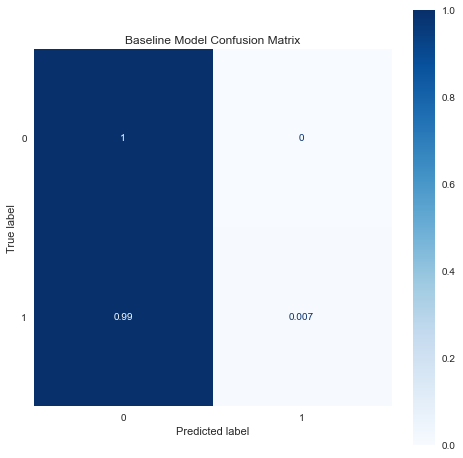

In [5]:
from sklearn.metrics import plot_confusion_matrix
plt.style.use('seaborn')

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(baseline_pipeline, X_test, y_test, ax=ax, normalize='true', cmap='Blues')
plt.title('Baseline Model Confusion Matrix')
plt.grid(False)
plt.show()

In [6]:
from sklearn.model_selection import GridSearchCV

lr_grid = {'baseline__C':[0.001, 0.1, 1], 'baseline__solver':['lbfgs', 'saga'], 'baseline__fit_intercept':[True, False]}
lr_gridsearch = GridSearchCV(estimator=baseline_pipeline, param_grid=lr_grid, scoring='recall', cv=5)
lr_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {lr_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {lr_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {lr_gridsearch.best_params_}')

Cross validation scores: [0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.0093844 0.0093844]
Best cross validation score: 0.94%
Optimal parameters: {'baseline__C': 1, 'baseline__fit_intercept': False, 'baseline__solver': 'lbfgs'}


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=112221)

dt_pipeline = Pipeline(steps=[('tfidf', tfidf), ('dt', dt_model)])
dt_pipeline.fit(X_train, y_train)

dt_y_pred = dt_pipeline.predict(X_test)
recall_score(y_test, dt_y_pred)

In [ ]:
dt_grid = {
    'dt__criterion':['gini', 'entropy'],
    'dt__splitter':['best', 'random'],
    'dt__max_depth':[2, 6, 10, 15],
    'dt__min_samples_split': [5, 10],
    'dt__min_samples_leaf': [3, 6],
}

dt_gridsearch = GridSearchCV(estimator=dt_pipeline, param_grid=dt_grid, scoring='recall', cv=5)
dt_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {dt_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {dt_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {dt_gridsearch.best_params_}')

In [ ]:
tuned_dt_model = DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=3, min_samples_split=10, splitter='random', random_state=112221)

tuned_dt_pipeline = Pipeline(steps=[('tfidf', tfidf), ('tuned_dt', tuned_dt_model)])
tuned_dt_pipeline.fit(X_train, y_train)

tuned_dt_y_pred = tuned_dt_pipeline.predict(X_test)
recall_score(y_test, tuned_dt_y_pred)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(tuned_dt_pipeline, X_test, y_test, ax=ax, normalize='true', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.grid(False)
plt.show()

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

In [ ]:
rf_model = RandomForestClassifier(random_state=112221)

rf_pipeline = Pipeline(steps=[('tfidf', tfidf), ('rf', rf_model)])
rf_pipeline.fit(X_train, y_train)

rf_y_pred = rf_pipeline.predict(X_test)
recall_score(y_test, rf_y_pred)

In [ ]:
rf_grid = {
    'rf__n_estimators':[10, 30, 100],
    'rf__criterion':['gini', 'entropy'],
    'rf__max_depth':[None, 2, 6, 10],
    'rf__min_samples_split':[5, 10],
    'rf__min_samples_leaf':[3, 6]
}

rf_gridsearch = GridSearchCV(estimator=rf_pipeline, param_grid=rf_grid, scoring='recall', cv=5)
rf_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {rf_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {rf_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {rf_gridsearch.best_params_}')

In [ ]:
rf_tuned_grid = {
    'rf__max_depth': [None, 8, 12], 
    'rf__min_samples_leaf':[1, 2, 3], 
    'rf__min_samples_split': [10, 15], 
    'rf__n_estimators': [100, 150]
}

rf_tuned_gridsearch = GridSearchCV(estimator=rf_pipeline, param_grid=rf_tuned_grid, scoring='recall', cv=5)
rf_tuned_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {rf_tuned_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {rf_tuned_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {rf_tuned_gridsearch.best_params_}')

In [ ]:
rf_tuned_grid_1 = {  
    'rf__min_samples_split': [15, 20, 25], 
    'rf__n_estimators': [150, 200, 300]
}

rf_tuned_gridsearch_1 = GridSearchCV(estimator=rf_pipeline, param_grid=rf_tuned_grid_1, scoring='recall', cv=5)
rf_tuned_gridsearch_1.fit(X_train, y_train)

print(f'Cross validation scores: {rf_tuned_gridsearch_1.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {rf_tuned_gridsearch_1.best_score_ :.2%}')
print(f'Optimal parameters: {rf_tuned_gridsearch_1.best_params_}')

In [ ]:
tuned_rf_model = RandomForestClassifier(min_samples_split=20, n_estimators=150, random_state=112221)

tuned_rf_pipeline = Pipeline(steps=[('tfidf', tfidf), ('tuned_rf', tuned_rf_model)])
tuned_rf_pipeline.fit(X_train, y_train)

tuned_rf_y_pred = tuned_rf_pipeline.predict(clean_X_test)
recall_score(y_test, tuned_rf_y_pred)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(tuned_rf_pipeline, X_test, y_test, ax=ax, normalize='true', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.grid(False)
plt.show()

# Extra Trees

In [ ]:
et_model = ExtraTreesClassifier(random_state=112221)

et_pipeline = Pipeline(steps=[('tfidf', tfidf), ('et', et_model)])
et_pipeline.fit(X_train, y_train)

et_y_pred = rf_pipeline.predict(X_test)
recall_score(y_test, et_y_pred)

In [ ]:
et_grid = {
    'et__n_estimators':[10, 30, 100],
    'et__criterion':['gini', 'entropy'],
    'et__max_depth':[None, 2, 6, 10],
    'et__min_samples_split':[5, 10],
    'et__min_samples_leaf':[3, 6]
}

et_gridsearch = GridSearchCV(estimator=et_pipeline, param_grid=et_grid, scoring='recall', cv=5)
et_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {et_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {et_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {et_gridsearch.best_params_}')

In [ ]:
et_tuned_grid = {
    'et__n_estimators':[100, 150, 200],
    'et__min_samples_split':[10, 15],
    'et__min_samples_leaf':[1, 2, 3]
}

et_tuned_gridsearch = GridSearchCV(estimator=et_pipeline, param_grid=et_tuned_grid, scoring='recall', cv=5)
et_tuned_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {et_tuned_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {et_tuned_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {et_tuned_gridsearch.best_params_}')

In [ ]:
# TUNE MORE if necessary
et_tuned_grid = {
    'et__n_estimators':[10, 30, 100],
    'et__criterion':['gini', 'entropy'],
    'et__max_depth':[None, 2, 6, 10],
    'et__min_samples_split':[5, 10],
    'et__min_samples_leaf':[3, 6]
}

et_tuned_gridsearch = GridSearchCV(estimator=et_pipeline, param_grid=et_tuned_grid, scoring='recall', cv=5)
et_tuned_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {et_tuned_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {et_tuned_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {et_tuned_gridsearch.best_params_}')

In [ ]:
tuned_et_model = ExtraTreesClassifier(max_depth=15, min_samples_leaf=3, min_samples_split=10, splitter='random', random_state=112221)

tuned_et_pipeline = Pipeline(steps=[('tfidf', tfidf), ('tuned_et', tuned_et_model)])
tuned_et_pipeline.fit(X_train, y_train)

tuned_et_y_pred = tuned_et_pipeline.predict(X_test)
recall_score(y_test, tuned_et_y_pred)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(tuned_et_pipeline, X_test, y_test, ax=ax, normalize='true', cmap='Blues')
plt.title('Extra Trees Confusion Matrix')
plt.grid(False)
plt.show()

# Gradient Boosting

In [ ]:
gb_model = GradientBoostingClassifier(random_state=112221)

gb_pipeline = Pipeline(steps=[('tfidf', tfidf), ('gb', gb_model)])
gb_pipeline.fit(X_train, y_train)

gb_y_pred = gb_pipeline.predict(X_test)
recall_score(y_test, gb_y_pred)

In [ ]:
gb_grid = {
    'gb__loss': ['deviance', 'exponential'],
    'gb__n_estimators':[10, 30, 100],
    'gb__criterion':['friedman_mse', 'squared_error'],
    'gb__max_depth':[2, 6, 10],
    'gb__min_samples_split':[5, 10],
    'gb__min_samples_leaf':[3, 6]
}

gb_gridsearch = GridSearchCV(estimator=gb_pipeline, param_grid=gb_grid, scoring='recall', cv=5)
gb_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {gb_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {gb_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {gb_gridsearch.best_params_}')

In [ ]:
gb_tuned_grid = {
    'gb__loss': ['deviance', 'exponential'],
    'gb__n_estimators':[10, 30, 100],
    'gb__criterion':['friedman_mse', 'squared_error'],
    'gb__max_depth':[2, 6, 10],
    'gb__min_samples_split':[5, 10],
    'gb__min_samples_leaf':[3, 6]
}

gb_tuned_gridsearch = GridSearchCV(estimator=gb_pipeline, param_grid=gb_tuned_grid, scoring='recall', cv=5)
gb_tuned_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {gb_tuned_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {gb_tuned_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {gb_tuned_gridsearch.best_params_}')

In [ ]:
tuned_gb_model = GradientBoostingClassifier(max_depth=15, min_samples_leaf=3, min_samples_split=10, splitter='random', random_state=112221)

tuned_gb_pipeline = Pipeline(steps=[('tfidf', tfidf), ('tuned_et', tuned_gb_model)])
tuned_gb_pipeline.fit(X_train, y_train)

tuned_gb_y_pred = tuned_gb_pipeline.predict(X_test)
recall_score(y_test, tuned_gb_y_pred)

# Stochastic Gradient Descent

In [ ]:
from sklearn.linear_model import SGDClassifier

In [ ]:
sgd_model = SGDClassifier(random_state=112221)

sgd_pipeline = Pipeline(steps=[('tfidf', tfidf), ('sgd', sgd_model)])
sgd_pipeline.fit(X_train, y_train)

sgd_y_pred = sgd_pipeline.predict(X_test)
recall_score(y_test, sgd_y_pred)

In [ ]:
sgd_grid = {
    'gb__loss': ['deviance', 'exponential'],
    'gb__n_estimators':[10, 30, 100],
    'gb__criterion':['friedman_mse', 'squared_error'],
    'gb__max_depth':[2, 6, 10],
    'gb__min_samples_split':[5, 10],
    'gb__min_samples_leaf':[3, 6]
}

sgd_gridsearch = GridSearchCV(estimator=sgd_pipeline, param_grid=sgd_grid, scoring='recall', cv=5)
sgd_gridsearch.fit(X_train, y_train)

print(f'Cross validation scores: {sgd_gridsearch.cv_results_["mean_test_score"]}')
print(f'Best cross validation score: {sgd_gridsearch.best_score_ :.2%}')
print(f'Optimal parameters: {sgd_gridsearch.best_params_}')

In [ ]:
tuned_sgd_model = SGDClassifier(max_depth=15, min_samples_leaf=3, min_samples_split=10, splitter='random', random_state=112221)

tuned_sgd_pipeline = Pipeline(steps=[('tfidf', tfidf), ('tuned_et', tuned_sgd_model)])
tuned_sgd_pipeline.fit(X_train, y_train)

tuned_sgd_y_pred = tuned_sgd_pipeline.predict(X_test)
recall_score(y_test, tuned_sgd_y_pred)